# **ResNext(2017): resnet의 bottleneck 부분을 변경한 모델.**
Grouped Convolution을 이용하였다는 점이 특징.
Cardinality : 채널 수를 몇개의 그룹으로 분할하는지를 조절하는 하이퍼 파라미터
[참고 블로그(논문)](https://deep-learning-study.tistory.com/533),
[참고 블로그(구현)](https://deep-learning-study.tistory.com/558),
[참고 깃허브1](https://github.com/Seonghoon-Yu/AI_Paper_Review/blob/master/Classification/ResNext(2017).ipynb),
[참고 깃허브 2](https://github.com/weiaicunzai/pytorch-cifar100/blob/master/models/resnext.py#L117)

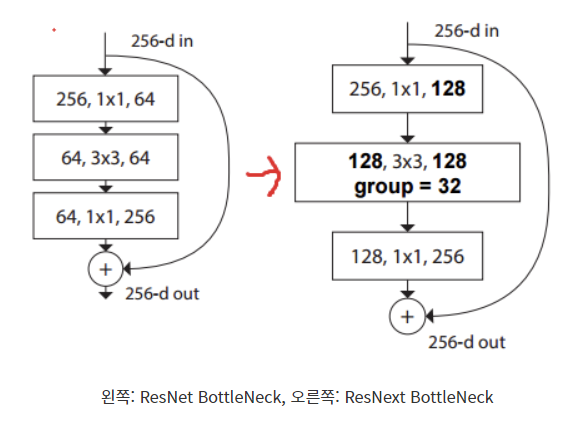

## colab setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/Gwangsang'

/content/drive/MyDrive/Gwangsang


##import package

In [2]:
#model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim

#utils
import numpy as np
from torchsummary import summary
import time
import copy

## data load

## model 구축

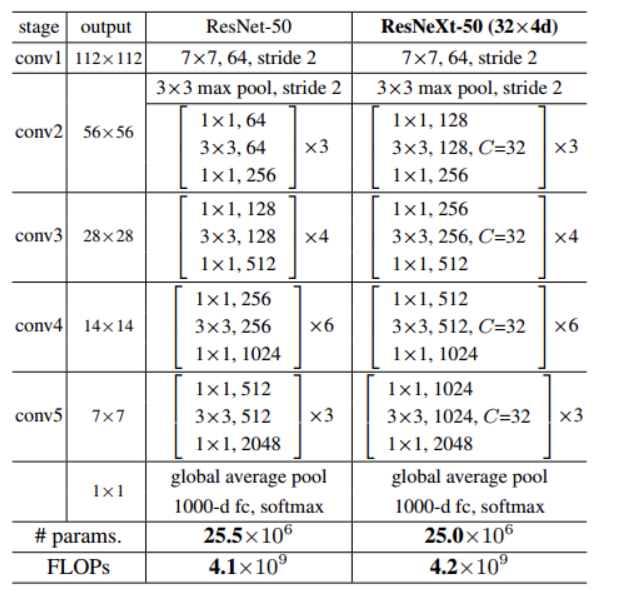

In [15]:
from torch.nn.modules.batchnorm import BatchNorm2d
class Bottle_Neck(nn.Module):
  expansion = 4 #2 아닌가??
  cardinality = 32
  basewidth = 64  # 기본 bottleneck 채널수  128아닌가???
  depth = 4  # basewidth 일 때, group convolution 의 채널 수

  def __init__(self, in_channels, out_channels, stride): #stride 는 왜 1인가?
    super().__init__()
    c = Bottle_Neck.cardinality
    d = int(Bottle_Neck.depth *out_channels /Bottle_Neck.basewidth)  #한 그룹의 채널 수 : 기본 채널 수에 대한 output채널 수의 비율로 표현

    self.conv_residual = nn.Sequential(
        nn.Conv2d(in_channels,c*d , kernel_size = 1 , groups = c, bias = False),
        nn.BatchNorm2d(c*d), #numfeatures = 입력채널의 개수
        nn.ReLU(),
        nn.Conv2d(c*d,c*d, kernel_size=3, stride = stride,padding =1, groups =c, bias = False),
        nn.BatchNorm2d(c*d),
        nn.ReLU(),
        nn.Conv2d(c*d,out_channels*Bottle_Neck.expansion,kernel_size=1,bias =False), #out channel왜 이렇지?
        nn.BatchNorm2d(out_channels*Bottle_Neck.expansion)
    )

    self.shortcut = nn.Sequential()

    if stride !=1 or in_channels != out_channels*Bottle_Neck.expansion: #그냥 더하는것이 아니라 처리를 해줌
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_channels, out_channels*4, stride = stride,kernel_size=1 , bias = False),
          nn.BatchNorm2d(out_channels*4)
      )

  def forward(self, x) :
      return F.relu(self.conv_residual(x)+self.shortcut(x))


In [21]:
class Res_Next(nn.Module):

  def __init__(self, num_blocks, num_classes=2 , init_weights = True):
    super().__init__()
    self.init_weights = init_weights
    self.in_channels = 64

    self.conv1 = nn.Sequential(
        nn.Conv2d(3,64,7,stride =2 , padding = 2 , bias = False), #패딩은 왜 2?
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(3, stride =2 , padding =1) #
    )

    self.conv2 = self._make_res_block(num_blocks[0],64,1)
    self.conv3 = self._make_res_block(num_blocks[1],128,2)
    self.conv4 = self._make_res_block(num_blocks[2],256,2)
    self.conv5 = self._make_res_block(num_blocks[3],512,2)

    self.avg_pool = nn.AdaptiveAvgPool2d((1,1)) #입력값에 상관없이 출력값의 사이즈를 맞춰주는 pooling
    self.linear = nn.Linear(512*Bottle_Neck.expansion , num_classes)

    if self.init_weights:
      self._initialize_weights()



  def forward(self,x):
      x = self.conv1(x)
      x = self.conv2(x)
      x = self.conv3(x)
      x = self.conv4(x)
      x = self.conv5(x)
      x = self.avg_pool(x)
      x = x.view(x.size(0), -1)
      x = self.linear(x)
      return x

  def _make_res_block(self, num_blocks, out_channels, stride):
      strides  = [stride]+[1]*(num_blocks-1) #strides = [stride, 1,1,...1]
      res_block = nn.Sequential()

      for i, stride in enumerate(strides):
        res_block.add_module('dense_layer_{}'.format(i),Bottle_Neck(self.in_channels,out_channels,stride))
        self.in_channels = out_channels*Bottle_Neck.expansion

      return res_block


  def _initialize_weights(self):
      for m in self.modules():
        if isinstance(m, nn.Conv2d):
          nn.init.kaiming_normal_(m.weight, mode ='fan_out', nonlinearity='relu') #he-normal(relu 함수 사용할 떄 0으로 수렴하는 문제 해결하기 위한)
          if m.bias is not None:
            nn.init.constant_(m.bias,0)
          elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight,1)
            nn.init.constant_(m.bias,0)
          elif isinstance(m, nn.Linear):
            nn.init.normal_(m.weight,0,0.01)
            nn.init.constant_(m.bias,0)



In [22]:
print([1]*2)
print([3]+[1]*2)

[1, 1]
[3, 1, 1]


In [23]:
def Res_Next50():
  return Res_Next([3,4,6,3])

In [24]:
#GPU로 학습할 때 모델과 데이터셋을 gpu에 올려놓아야 함
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x = torch.randn((3,3,224,224)).to(device)

In [25]:

model = Res_Next50().to(device)
summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 111, 111]           9,408
       BatchNorm2d-2         [-1, 64, 111, 111]             128
              ReLU-3         [-1, 64, 111, 111]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]             256
       BatchNorm2d-6          [-1, 128, 56, 56]             256
              ReLU-7          [-1, 128, 56, 56]               0
            Conv2d-8          [-1, 128, 56, 56]           4,608
       BatchNorm2d-9          [-1, 128, 56, 56]             256
             ReLU-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          32,768
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## training

In [ ]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr =0.01)

from torch.optim.lr_scheduler import ReduceLROnPlateau
# optimizer값을 관찰하여 최솟값이되어야 하며, 콜백함수가 시작되면 기존 learning rate *factor를 수행, 10회이상 값의개선이 없을 경우 콜백함수 실행
lr_scheduler = ReduceLROnPlateau(optimizer, mode ='min',factor=0.1,patience =10)

def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

def metric_batch(loss_func, output, target, optimizer = None)

